# Get setup

In [ ]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 26.70 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Create Datasets and DataLoaders

In [ ]:
from going_modular.going_modular import data_setup
from torchvision import transforms

# create image size
IMG_SIZE = 224

# create a manual transform
manual_transforms = transforms.Compose([
    transforms.Resize(size = (IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# create a batch size of 32
BATCH_SIZE = 32

# create Dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE)

## Visualize a single a image

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

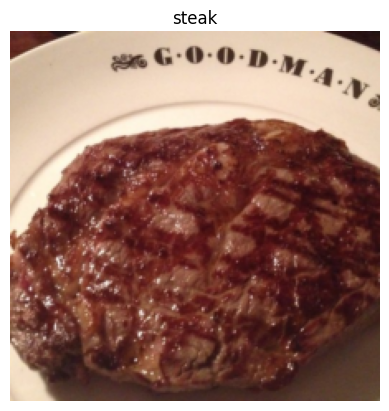

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False)

# Replicating ViT(vision transformer): Overview

# Equation 1: Split data into patches and creating the class, position and patch embedding

## Calculate input and output shapes by hand

In [ ]:
# creating example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# calculate the number of patches
number_of_patches = int((height * width) / patch_size ** 2)
number_of_patches

196

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


## Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

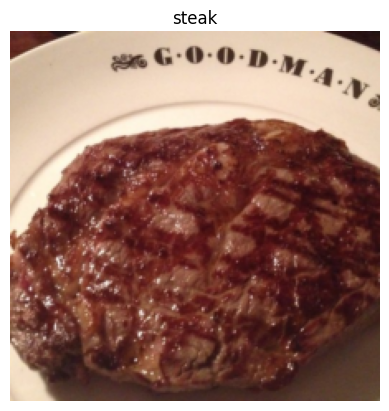

In [ ]:
# view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
image.shape

torch.Size([3, 224, 224])

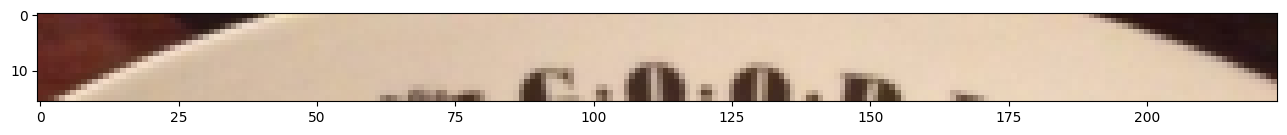

In [ ]:
# get the top row
image_permuted = image.permute(1,2,0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row : 14.0 
Patch size: 16 pixels x 16 pixels


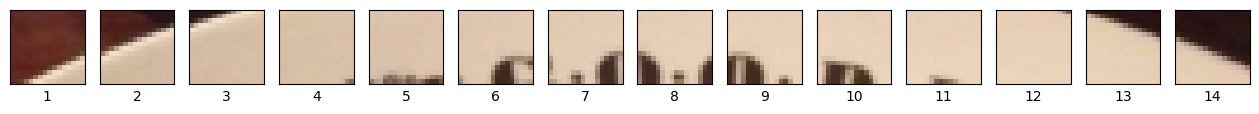

In [ ]:
# setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size%patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row : {num_patches} \nPatch size: {patch_size} pixels x {patch_size} pixels")

# create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i , patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


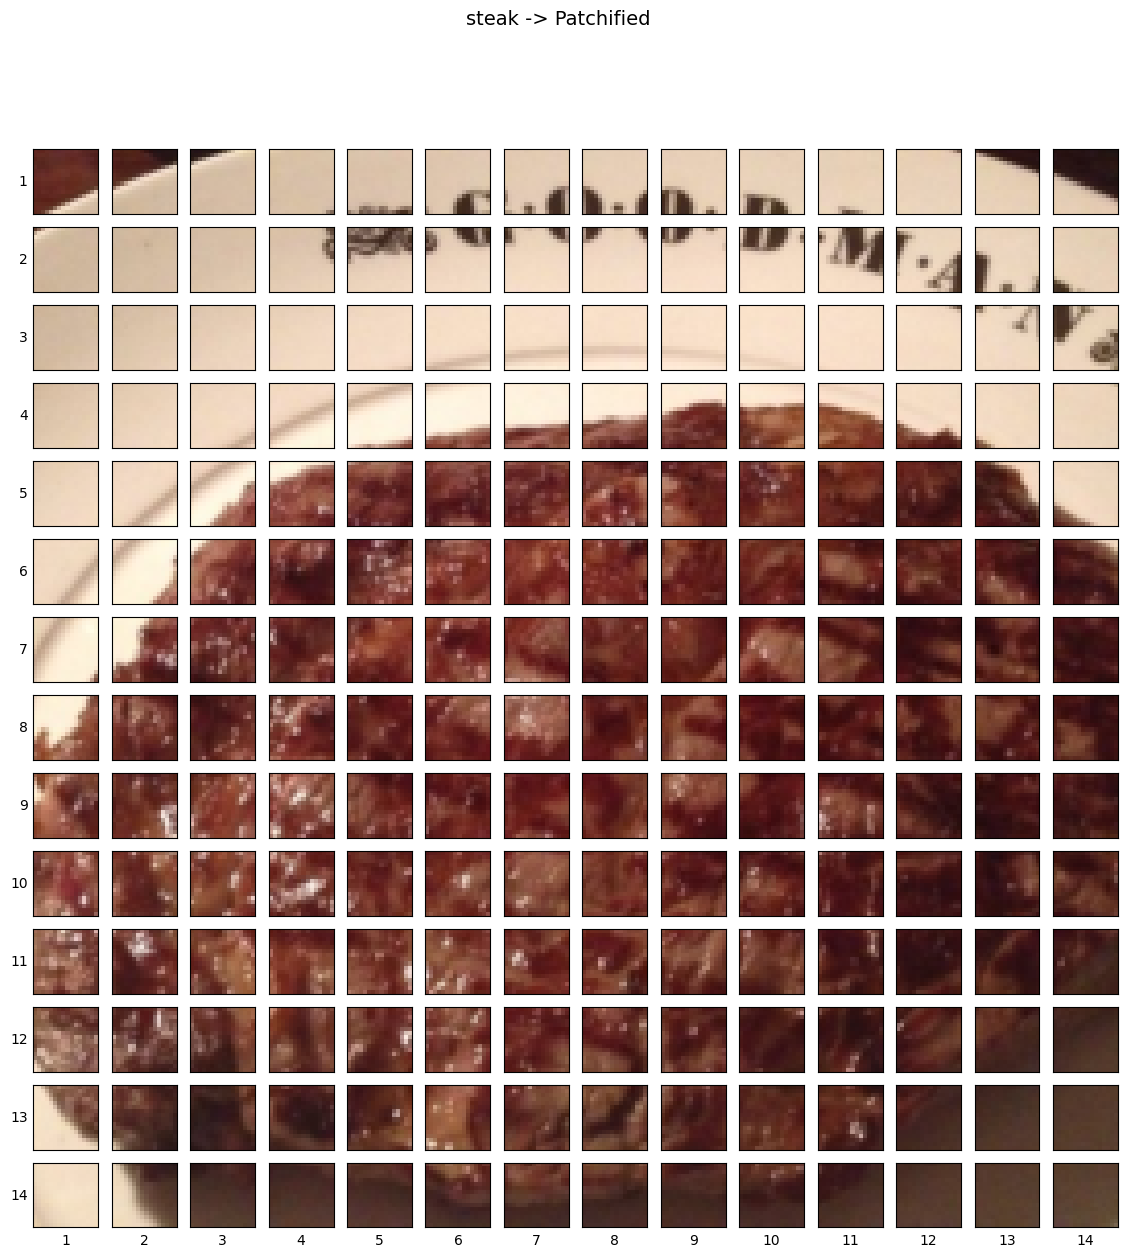

In [ ]:
# setup code to plot whole image as patch
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size%patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axes
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :]) # get all color channels
    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

## Creating image patches and turning them into patch embeddings

In [ ]:
from torch import nn

# set the patch size
patch_size = 16

# create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768, # D size from the table 1
                   kernel_size = 16,
                   stride = patch_size,
                   padding = 0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

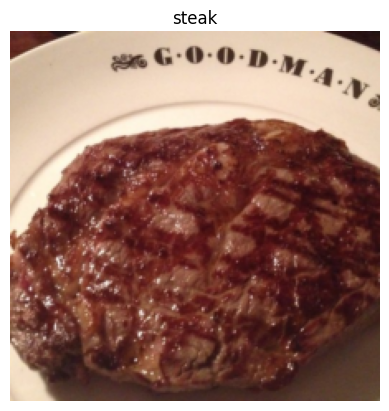

In [ ]:
# view single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
# pass the image through the convolution layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [ ]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [251, 108, 279, 423, 593]


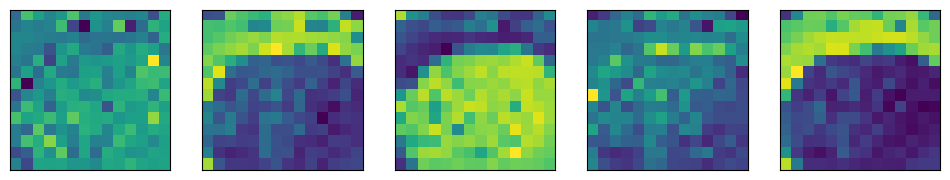

In [ ]:
# plot random convolutional feature map (embeddings)
import random

random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.4090, 0.3476, 0.3943, 0.5376, 0.5546, 0.3494, 0.4892, 0.4725,
           0.7023, 0.4153, 0.5829, 0.5471, 0.3486, 0.3060],
          [0.4919, 0.5207, 0.5300, 0.5821, 0.3867, 0.3851, 0.4805, 0.5477,
           0.4815, 0.4325, 0.4746, 0.4228, 0.5297, 0.5885],
          [0.5214, 0.5416, 0.5650, 0.5810, 0.5994, 0.5607, 0.6047, 0.6258,
           0.6042, 0.6053, 0.6156, 0.5770, 0.4985, 0.3362],
          [0.5459, 0.5769, 0.5711, 0.6587, 0.6240, 0.4072, 0.4919, 0.4866,
           0.4885, 0.4567, 0.4544, 0.3848, 0.6011, 0.5749],
          [0.5792, 0.5656, 0.4177, 0.4103, 0.2917, 0.2594, 0.2472, 0.2505,
           0.1865, 0.2450, 0.2179, 0.1604, 0.2898, 0.6061],
          [0.5449, 0.5843, 0.4118, 0.1958, 0.2812, 0.2323, 0.2390, 0.2144,
           0.2165, 0.2391, 0.1399, 0.1512, 0.2004, 0.2128],
          [0.6365, 0.2748, 0.1908, 0.2554, 0.2800, 0.2542, 0.2618, 0.2036,
           0.1962, 0.2238, 0.1965, 0.1201, 0.2316, 0.1306],
          [0.4280, 0.2334, 0.1532, 0.2386, 0.1513, 0.20

## Flattening the patch embedding with `torch.nn.Flatten()`

In [ ]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


In [ ]:
from torch import nn

flatten_layer = nn.Flatten(start_dim =2,
                           end_dim = 3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape : torch.Size([3, 224, 224])
Image feature map (patches) shape : torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


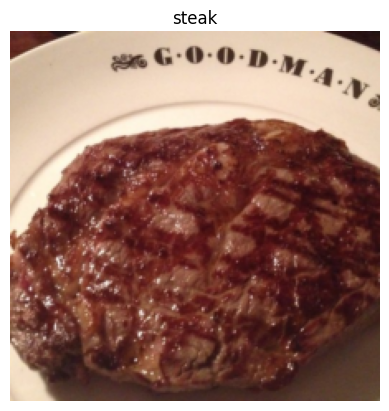

In [ ]:
# putting everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape : {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map (patches) shape : {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


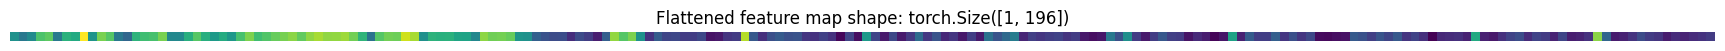

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

## Turning the ViT patch embedding layer into a PyTorch module

In [ ]:
# creating a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels : int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from table 1 for ViT base
    super().__init__()

    self.patch_size = patch_size

    # create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size=patch_size,
                             stride = patch_size,
                             padding =0)

    # create a layer to flatten the feature map outputs of conv2d
    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)

  # Define a forward method to define the forward computation steps
  def forward(self, x):
    # create an assertion to check that imputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # Make the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0,2,1)

In [ ]:
set_seeds()

# create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels =3,
                          patch_size = 16,
                          embedding_dim = 768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.randn(1,3,250,250)

# patchify(rand_image_tensor_bad)

## Creating the class token embedding

In [ ]:
patch_embedded_image

tensor([[[-0.4803,  0.1372, -0.1725,  ...,  0.3855, -0.2007,  0.1701],
         [-0.6634,  0.0592, -0.3321,  ...,  0.3733,  0.0227,  0.3025],
         [-1.0593,  0.3210, -0.2447,  ...,  0.5578, -0.3301,  0.2140],
         ...,
         [-0.2987,  0.0481, -0.0861,  ...,  0.1787, -0.1216,  0.1063],
         [-0.3104,  0.0411, -0.0755,  ...,  0.1950, -0.1389,  0.1186],
         [-0.3430,  0.0393, -0.0956,  ...,  0.2082, -0.1369,  0.1117]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
# get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
# create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
# add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number of patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4803,  0.1372, -0.1725,  ...,  0.3855, -0.2007,  0.1701],
         [-0.6634,  0.0592, -0.3321,  ...,  0.3733,  0.0227,  0.3025],
         ...,
         [-0.2987,  0.0481, -0.0861,  ...,  0.1787, -0.1216,  0.1063],
         [-0.3104,  0.0411, -0.0755,  ...,  0.1950, -0.1389,  0.1186],
         [-0.3430,  0.0393, -0.0956,  ...,  0.2082, -0.1369,  0.1117]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


## Creating the position embedding

In [ ]:
# calculate N (number of patches)
number_of_patches = int((height*width) / patch_size**2)

# get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# view the sequence of patch embeddings with the prepended class embeddings
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4803,  0.1372, -0.1725,  ...,  0.3855, -0.2007,  0.1701],
          [-0.6634,  0.0592, -0.3321,  ...,  0.3733,  0.0227,  0.3025],
          ...,
          [-0.2987,  0.0481, -0.0861,  ...,  0.1787, -0.1216,  0.1063],
          [-0.3104,  0.0411, -0.0755,  ...,  0.1950, -0.1389,  0.1186],
          [-0.3430,  0.0393, -0.0956,  ...,  0.2082, -0.1369,  0.1117]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5197, 1.1372, 0.8275,  ..., 1.3855, 0.7993, 1.1701],
         [0.3366, 1.0592, 0.6679,  ..., 1.3733, 1.0227, 1.3025],
         ...,
         [0.7013, 1.0481, 0.9139,  ..., 1.1787, 0.8784, 1.1063],
         [0.6896, 1.0411, 0.9245,  ..., 1.1950, 0.8611, 1.1186],
         [0.6570, 1.0393, 0.9044,  ..., 1.2082, 0.8631, 1.1117]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


## Putting it all together: from image to embedding

In [ ]:
set_seeds()

# set the patch_size
patch_size = 16

# Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# get the image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       patch_size = patch_size,
                                       embedding_dim = 768)

# pass input image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape : {patch_embedding.shape}")

# create class embedding token
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# prepend the class_token to the patch_embedding_layer
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# add the position embedding to th patch embedding class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape} ")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape : torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768]) 


# Equation 2: Multihead Self-Attention (MSA block)

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block which is MSA block for short"""
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:int=0):
    super().__init__()

    # create the norm layer(LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # create nulti head self attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first=True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x,
                                       key = x,
                                       value = x,
                                         need_weights=False)
    return attn_output

In [ ]:
# create an instance of MSA Block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim = 768,
                                                      num_heads = 12,
                                                      attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


# Equation 3: Multilayer Perceptron (MLP block)

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    # Create the norm layer(LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features = mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


# Creating the Transformer Encoder

## Create a custom Transformer Encoder block

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:int=0.1,
               attn_dropot:int=0):
    super().__init__()

    # create the MSA Block
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                            num_heads=num_heads,
                                            attn_dropout=attn_dropot)

    # create the MLP block
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                           mlp_size=mlp_size,
                           dropout=mlp_dropout)


  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [ ]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## Create a Transformer Encoder layer with in-built PyTorch layers

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1
                                                             nhead=12, # heads from table 1
                                                             dim_feedforward=3072, # MLP size from table
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

# Putting it all together to create ViT

In [ ]:
# create a vit base class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1,
               num_classes:int=1000):
    super().__init__()
    # make an assertion
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}"

    # calculate the number of patches
    self.num_patches = (img_size * img_size) // patch_size ** 2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # create the positional embedding
    self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches+1, embedding_dim))

    # create embeddingdropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # create the transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )


  def forward(self, x):
    # get the batch size
    batch_size = x.shape[0]

    # create the class token embedding and expand it to match the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # create the patch embedding
    x = self.patch_embedding(x)

    # concat class token embedding and patch_embedding(equation 1)
    x = torch.cat((class_token , x), dim=1)

    # add the position embedding to class token and position embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding ("directly after adding positional- to patch embeddings")
    x = self.embedding_dropout(x)

    # pass the patch embedding to the transformer encoder (equation 2 and 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])

    return x

In [ ]:
batch_size=32
embedding_dim=768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                              requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [ ]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

## Getting a visual summary of our ViT model

In [ ]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

In [ ]:
# Number of parameters in pretrained ViT
num_params = 85,800,963
num_params

(85, 800, 963)

# Setting up training code for our custom ViT

## Creating an optimizer

## Creating a loss function

## Training our ViT Model

In [ ]:
device

'cuda'

In [ ]:
from going_modular.going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.0393 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3047 | test_loss: 1.5085 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4133 | train_acc: 0.2617 | test_loss: 1.4602 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2590 | train_acc: 0.4102 | test_loss: 1.9581 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.2812 | test_loss: 1.6453 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2523 | train_acc: 0.2969 | test_loss: 1.7504 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.4102 | test_loss: 3.2498 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3791 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3394 | train_acc: 0.3672 | test_loss: 1.2890 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4096 | train_acc: 0.3164 | test_loss: 1.3272 | test_acc: 0.2604


## What our training setup is missing

## Plotting loss curves for our model

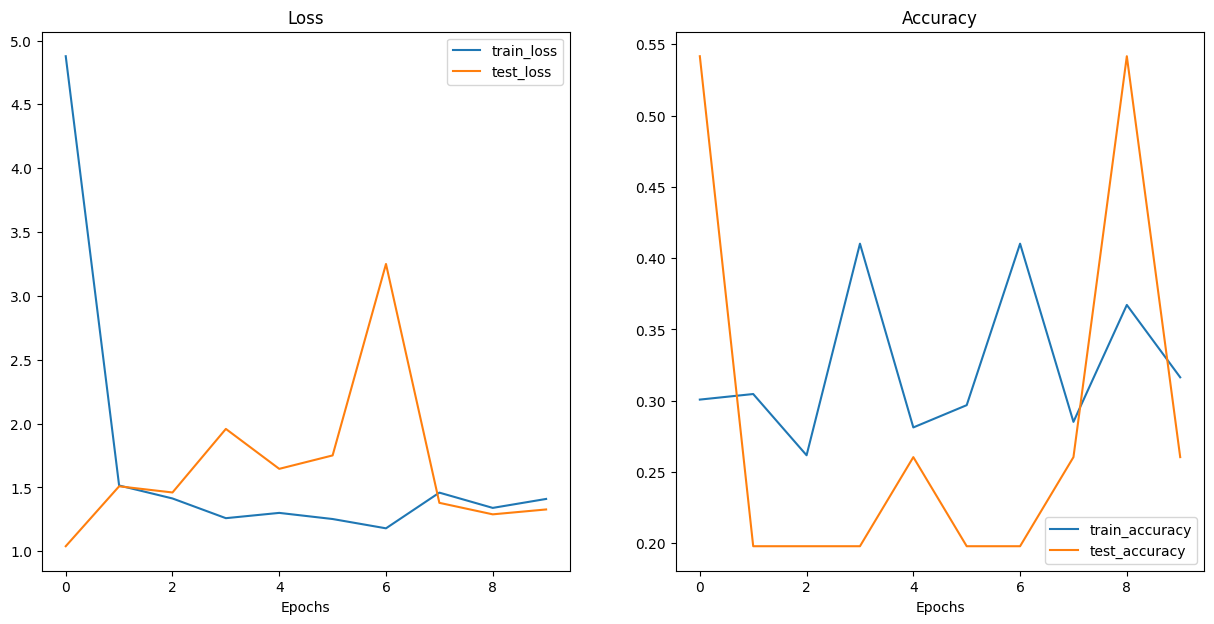

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

# Using a pretrained ViT from `torchvision.models`

## Why use a pretrained model?

In [ ]:
# Cost of a TPUv3 for 30 days
cost = 30*24*8
print(f"Cost of renting a TPUv3 for 30 straight days: ${cost}USD")

Cost of renting a TPUv3 for 30 straight days: $5760USD


In [ ]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [ ]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 78.3MB/s]


In [ ]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Preparing data for the pretrained ViT model

In [ ]:
# Get automtic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # could set a higher batch size because using a pretrained model

## Train feature extractor ViT model

In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


## Plot the loss curves of our pretrained ViT feature extractor model

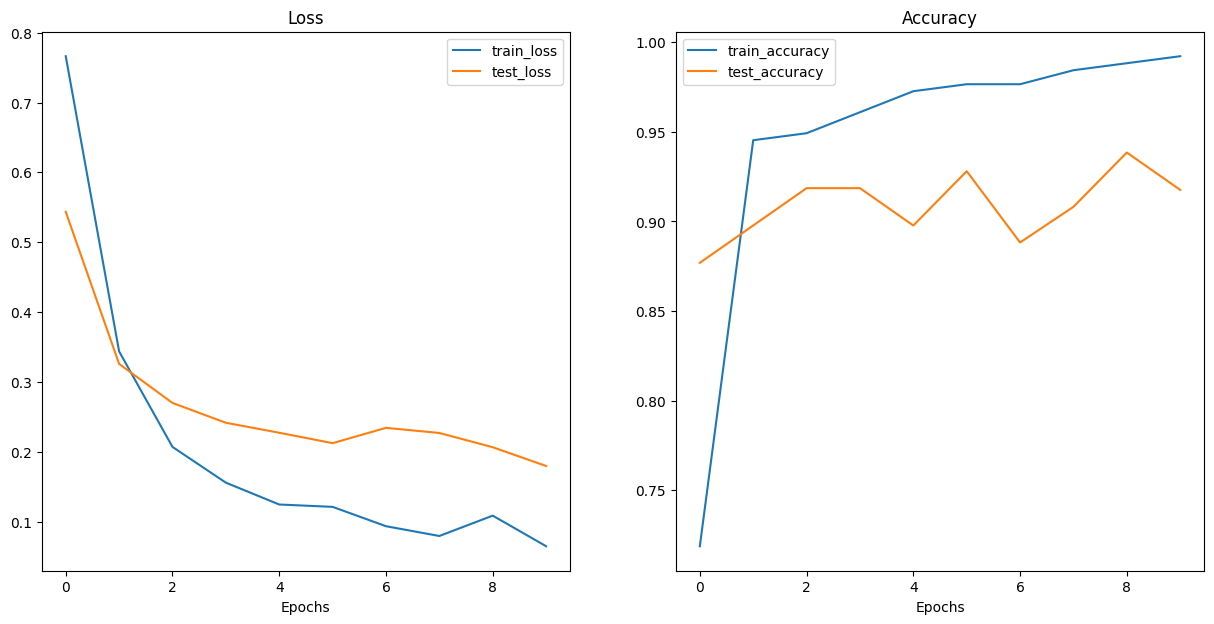

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## Save our best performing ViT model

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## Predicting on a custom image

data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


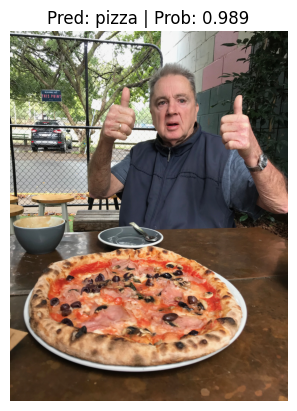

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)